# PMEmo Dataset - Feed Forward Neural Network
## Essentia Best Arousal Mean Featureset

## Import relevant libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torcheval.metrics import R2Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import math

import sys
sys.path.insert(1, '../../utils')
from paths import *

## Neural Network Training

### Import annotations dataset

In [2]:
df_annotations = pd.read_csv(get_pmemo_path('processed/annotations/pmemo_static_annotations.csv'))
df_annotations

,song_id,valence_mean_mapped,arousal_mean_mapped
0,1,0.150,-0.200
1,4,-0.425,-0.475
2,5,-0.600,-0.700
3,6,-0.300,0.025
4,7,0.450,0.400
...,...,...,...
762,993,0.525,0.725
763,996,0.125,0.750
764,997,0.325,0.425
765,999,0.550,0.750


### Import the featureset

This is where you should change between normalised and standardised, and untouched featuresets!

In [3]:
df_essentia_best_arousal_features_mean = pd.read_csv(get_pmemo_path('processed/features/normalised_essentia_best_arousal_features_mean.csv'))

# drop Unnamed:0 column
df_essentia_best_arousal_features_mean = df_essentia_best_arousal_features_mean[df_essentia_best_arousal_features_mean.columns[1:]]

df_essentia_best_arousal_features_mean

,song_id,lowlevel.average_loudness,lowlevel.barkbands_spread.mean,lowlevel.melbands_crest.mean,lowlevel.melbands_flatness_db.mean,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.melbands_spread.mean,lowlevel.spectral_energy.mean,lowlevel.spectral_entropy.mean,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,1,0.984985,0.579073,0.466983,0.314570,0.064362,0.214289,0.548723,0.125964,0.763577,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.089160,0.000000,0.223899,0.098657,0.288181
1,4,0.952336,0.071979,0.811687,0.690897,0.345452,0.539877,0.075821,0.949078,0.593323,...,0.016972,0.077021,0.402838,0.000000,0.030457,0.117746,0.000000,0.107674,0.000000,0.155779
2,5,0.944813,0.188384,0.658175,0.666715,0.566046,0.636537,0.194606,0.525953,0.615791,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008505,0.007329,0.000000,0.000000,0.000000
3,6,0.968798,0.355408,0.721706,0.523877,0.168166,0.426521,0.216854,0.278434,0.710481,...,0.000000,0.063161,0.000000,0.000000,0.000000,0.000000,0.000000,0.051213,0.000000,0.000000
4,7,0.985253,0.434349,0.197786,0.252470,0.050890,0.193447,0.451415,0.201743,0.764426,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.165104,0.096976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,993,0.914366,0.429802,0.301846,0.288119,0.058467,0.186511,0.460787,0.184759,0.768472,...,0.000000,0.000000,0.000000,0.031499,0.000000,0.000000,0.000000,0.013240,0.156009,0.863862
763,996,0.937592,0.571015,0.235807,0.188595,0.121857,0.234562,0.547003,0.179638,0.943027,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044460,0.016906
764,997,0.927177,0.793285,0.353024,0.220160,0.046206,0.200557,0.623593,0.195031,0.925110,...,0.008208,0.025688,0.000000,0.053602,0.000000,0.027702,0.000000,0.149709,0.035320,0.149458
765,999,0.969786,0.915269,0.395830,0.204894,0.063658,0.238118,0.586678,0.238011,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.005471,0.000000,0.051231,0.000000,0.112450,0.019859


In [4]:
df_essentia_best_arousal_features_mean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 305 columns):
 #    Column                                   Dtype  
---   ------                                   -----  
 0    song_id                                  int64  
 1    lowlevel.average_loudness                float64
 2    lowlevel.barkbands_spread.mean           float64
 3    lowlevel.melbands_crest.mean             float64
 4    lowlevel.melbands_flatness_db.mean       float64
 5    lowlevel.melbands_kurtosis.mean          float64
 6    lowlevel.melbands_skewness.mean          float64
 7    lowlevel.melbands_spread.mean            float64
 8    lowlevel.spectral_energy.mean            float64
 9    lowlevel.spectral_entropy.mean           float64
 10   lowlevel.spectral_flux.mean              float64
 11   lowlevel.spectral_kurtosis.mean          float64
 12   lowlevel.spectral_rolloff.mean           float64
 13   lowlevel.spectral_skewness.mean          float64
 14   rhythm.b

Join both the featureset and annotation set together

In [5]:
df_essentia_best_arousal_features_mean_whole = pd.merge(df_essentia_best_arousal_features_mean, df_annotations, how='inner', on='song_id')
df_essentia_best_arousal_features_mean_whole = df_essentia_best_arousal_features_mean_whole.drop('song_id', axis=1)
df_essentia_best_arousal_features_mean_whole

,lowlevel.average_loudness,lowlevel.barkbands_spread.mean,lowlevel.melbands_crest.mean,lowlevel.melbands_flatness_db.mean,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.melbands_spread.mean,lowlevel.spectral_energy.mean,lowlevel.spectral_entropy.mean,lowlevel.spectral_flux.mean,...,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23,valence_mean_mapped,arousal_mean_mapped
0,0.984985,0.579073,0.466983,0.314570,0.064362,0.214289,0.548723,0.125964,0.763577,0.485793,...,0.000000,0.000000,0.000000,0.089160,0.000000,0.223899,0.098657,0.288181,0.150,-0.200
1,0.952336,0.071979,0.811687,0.690897,0.345452,0.539877,0.075821,0.949078,0.593323,0.838254,...,0.402838,0.000000,0.030457,0.117746,0.000000,0.107674,0.000000,0.155779,-0.425,-0.475
2,0.944813,0.188384,0.658175,0.666715,0.566046,0.636537,0.194606,0.525953,0.615791,0.560126,...,0.000000,0.000000,0.000000,0.008505,0.007329,0.000000,0.000000,0.000000,-0.600,-0.700
3,0.968798,0.355408,0.721706,0.523877,0.168166,0.426521,0.216854,0.278434,0.710481,0.337842,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.051213,0.000000,0.000000,-0.300,0.025
4,0.985253,0.434349,0.197786,0.252470,0.050890,0.193447,0.451415,0.201743,0.764426,0.762925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.165104,0.096976,0.450,0.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,0.914366,0.429802,0.301846,0.288119,0.058467,0.186511,0.460787,0.184759,0.768472,0.590104,...,0.000000,0.031499,0.000000,0.000000,0.000000,0.013240,0.156009,0.863862,0.525,0.725
763,0.937592,0.571015,0.235807,0.188595,0.121857,0.234562,0.547003,0.179638,0.943027,0.706776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044460,0.016906,0.125,0.750
764,0.927177,0.793285,0.353024,0.220160,0.046206,0.200557,0.623593,0.195031,0.925110,0.551323,...,0.000000,0.053602,0.000000,0.027702,0.000000,0.149709,0.035320,0.149458,0.325,0.425
765,0.969786,0.915269,0.395830,0.204894,0.063658,0.238118,0.586678,0.238011,1.000000,0.661528,...,0.000000,0.000000,0.005471,0.000000,0.051231,0.000000,0.112450,0.019859,0.550,0.750


#### Prepare dataframes for the neural network

Perform splitting of the dataframe into training and testing sets

In [6]:
features = df_essentia_best_arousal_features_mean.drop('song_id', axis=1)
features

,lowlevel.average_loudness,lowlevel.barkbands_spread.mean,lowlevel.melbands_crest.mean,lowlevel.melbands_flatness_db.mean,lowlevel.melbands_kurtosis.mean,lowlevel.melbands_skewness.mean,lowlevel.melbands_spread.mean,lowlevel.spectral_energy.mean,lowlevel.spectral_entropy.mean,lowlevel.spectral_flux.mean,...,tonal.chords_histogram_14,tonal.chords_histogram_15,tonal.chords_histogram_16,tonal.chords_histogram_17,tonal.chords_histogram_18,tonal.chords_histogram_19,tonal.chords_histogram_20,tonal.chords_histogram_21,tonal.chords_histogram_22,tonal.chords_histogram_23
0,0.984985,0.579073,0.466983,0.314570,0.064362,0.214289,0.548723,0.125964,0.763577,0.485793,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.089160,0.000000,0.223899,0.098657,0.288181
1,0.952336,0.071979,0.811687,0.690897,0.345452,0.539877,0.075821,0.949078,0.593323,0.838254,...,0.016972,0.077021,0.402838,0.000000,0.030457,0.117746,0.000000,0.107674,0.000000,0.155779
2,0.944813,0.188384,0.658175,0.666715,0.566046,0.636537,0.194606,0.525953,0.615791,0.560126,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.008505,0.007329,0.000000,0.000000,0.000000
3,0.968798,0.355408,0.721706,0.523877,0.168166,0.426521,0.216854,0.278434,0.710481,0.337842,...,0.000000,0.063161,0.000000,0.000000,0.000000,0.000000,0.000000,0.051213,0.000000,0.000000
4,0.985253,0.434349,0.197786,0.252470,0.050890,0.193447,0.451415,0.201743,0.764426,0.762925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.165104,0.096976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,0.914366,0.429802,0.301846,0.288119,0.058467,0.186511,0.460787,0.184759,0.768472,0.590104,...,0.000000,0.000000,0.000000,0.031499,0.000000,0.000000,0.000000,0.013240,0.156009,0.863862
763,0.937592,0.571015,0.235807,0.188595,0.121857,0.234562,0.547003,0.179638,0.943027,0.706776,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044460,0.016906
764,0.927177,0.793285,0.353024,0.220160,0.046206,0.200557,0.623593,0.195031,0.925110,0.551323,...,0.008208,0.025688,0.000000,0.053602,0.000000,0.027702,0.000000,0.149709,0.035320,0.149458
765,0.969786,0.915269,0.395830,0.204894,0.063658,0.238118,0.586678,0.238011,1.000000,0.661528,...,0.000000,0.000000,0.000000,0.000000,0.005471,0.000000,0.051231,0.000000,0.112450,0.019859


In [7]:
targets = df_annotations.drop('song_id', axis=1)
targets

,valence_mean_mapped,arousal_mean_mapped
0,0.150,-0.200
1,-0.425,-0.475
2,-0.600,-0.700
3,-0.300,0.025
4,0.450,0.400
...,...,...
762,0.525,0.725
763,0.125,0.750
764,0.325,0.425
765,0.550,0.750


Perform 80-20 train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)

Create tensors for X_train and X_test

In [9]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float64)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float64)

Create tensors for Y_train and Y_test

In [10]:
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float64)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float64)

Define neural network parameters and instantitate neural network

In [11]:
input_size = 1
hidden_size = 20 
output_size = 2  # Output size for valence and arousal
learning_rate = 0.001
criterion = nn.MSELoss()

In [12]:
num_epochs = 111

Set a random seed to ensure consistent initial weights of the neural network

In [13]:
# Set the seed
seed = 42
torch.manual_seed(seed)

Define the neural network

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), math.ceil((input_size**0.5) * 2)),
            nn.ReLU(),
            nn.Linear(math.ceil((input_size**0.5) * 2), 2)
        )

    def forward(self, x):
        return self.layers(x)

#### Training

Prepare input_train_data and target_train_labels

In [15]:
input_train_data = X_train_tensor.float()

# input_train_data = input_train_data.view(input_train_data.shape[1], -1)
print(input_train_data.shape)

target_train_labels = y_train_tensor

torch.Size([613, 304])


Training loop

In [16]:
def train_model(num_epochs):
  model = NeuralNetwork(input_size=input_train_data.shape[1])
  optimiser = optim.Adam(model.parameters(), lr=learning_rate)
  
  for epoch in range(num_epochs):
    optimiser.zero_grad()
    
    # forward pass
    output = model(input_train_data)

    # calculate loss
    loss = torch.sqrt(criterion(output.float(), target_train_labels.float()))

    # backward pass
    loss.backward()
    # update weights
    optimiser.step()

    print(f'Epoch {epoch + 1}, Loss: {math.sqrt(loss.item())}')

  print("Training completed.")
  return model

In [17]:
model = train_model(num_epochs)

Epoch 1, Loss: 0.6597031161123814
Epoch 2, Loss: 0.656605873799551
Epoch 3, Loss: 0.6535210407988056
Epoch 4, Loss: 0.6503875319948625
Epoch 5, Loss: 0.647256257859055
Epoch 6, Loss: 0.6441351395854026
Epoch 7, Loss: 0.6410230702415904
Epoch 8, Loss: 0.6379166316882257
Epoch 9, Loss: 0.6348954522807412
Epoch 10, Loss: 0.6318483660977546
Epoch 11, Loss: 0.6288034343196786
Epoch 12, Loss: 0.6257689752220208
Epoch 13, Loss: 0.622768064675636
Epoch 14, Loss: 0.6198322512591645
Epoch 15, Loss: 0.6169952382842182
Epoch 16, Loss: 0.6142244314757267
Epoch 17, Loss: 0.6115146876354594
Epoch 18, Loss: 0.6088665773047627
Epoch 19, Loss: 0.6063658436477279
Epoch 20, Loss: 0.6039324311852292
Epoch 21, Loss: 0.6016328448496068
Epoch 22, Loss: 0.5994741430218481
Epoch 23, Loss: 0.5975562367250178
Epoch 24, Loss: 0.5959313627666157
Epoch 25, Loss: 0.5945818244186035
Epoch 26, Loss: 0.5935377444290209
Epoch 27, Loss: 0.5928172012086385
Epoch 28, Loss: 0.5924098551055365
Epoch 29, Loss: 0.59227516813732

## Neural Network Testing

Prepare input_test_data and target_test_labels

In [18]:
input_test_data = X_test_tensor.float()

# input_test_data = input_test_data.view(input_test_data.shape[1], -1)
print(input_test_data.shape)

target_test_labels = y_test_tensor

torch.Size([154, 304])


Generating scores

In [19]:
def test_model(trained_model):
  with torch.no_grad():
    test_pred = trained_model(input_test_data)
    test_loss = criterion(test_pred.float(), target_test_labels)

    # Separate the output into valence and arousal
    valence_pred = test_pred[:, 0]
    arousal_pred = test_pred[:, 1]
        
    valence_target = target_test_labels[:, 0]
    arousal_target = target_test_labels[:, 1]

     # Calculate RMSE for valence and arousal separately
    valence_rmse = math.sqrt(mean_squared_error(valence_pred, valence_target))
    arousal_rmse = math.sqrt(mean_squared_error(arousal_pred, arousal_target))

  rmse = math.sqrt(test_loss.item())
  print(f'Test RMSE: {rmse}')

  print(f'Valence RMSE: {valence_rmse}')
  print(f'Arousal RMSE: {arousal_rmse}')

  metric = R2Score(multioutput="raw_values")
  metric.update(test_pred, target_test_labels)
  adjusted_r2_score = metric.compute()
  print(f'Test R^2 score: {adjusted_r2_score}')

  # metric = R2Score(multioutput="raw_values", num_regressors=input_test_data.shape[1])
  # metric.update(test_pred, target_test_labels)
  # adjusted_r2_score = metric.compute()
  # print(f'Test Adjusted R^2 score: {adjusted_r2_score}')

  metric = R2Score()
  metric.update(test_pred, target_test_labels)
  r2_score = metric.compute()
  print(f'Test R^2 score (overall): {r2_score}')
  return test_pred, rmse, adjusted_r2_score, r2_score

In [20]:
test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)

Test RMSE: 0.252418742693043
Valence RMSE: 0.24661390906679054
Arousal RMSE: 0.25809305139865746
Test R^2 score: tensor([0.3501, 0.5087], dtype=torch.float64)
Test R^2 score (overall): 0.4294175562780569


In [21]:
torch.save(model.state_dict(), '../../models/pmemo_feedforward_nn_essentia_best_arousal_mean_normalised.pt')

True values (test set)

In [22]:
target_test_labels

tensor([[-0.5750,  0.3500],
        [ 0.1250, -0.0250],
        [ 0.2000,  0.4750],
        [ 0.3500,  0.3500],
        [ 0.3000,  0.4500],
        [ 0.3500,  0.0250],
        [ 0.3250, -0.0250],
        [ 0.3750,  0.3500],
        [ 0.1500,  0.1000],
        [ 0.2750,  0.6500],
        [ 0.5000,  0.5250],
        [ 0.0500, -0.3500],
        [ 0.0500,  0.2250],
        [-0.3250, -0.4500],
        [-0.1000,  0.4500],
        [ 0.1250, -0.4000],
        [ 0.3750,  0.5500],
        [ 0.2000, -0.2250],
        [-0.4500, -0.3000],
        [ 0.0500,  0.0750],
        [ 0.2750,  0.4250],
        [-0.0250,  0.4000],
        [ 0.6500,  0.6750],
        [-0.1750, -0.3250],
        [-0.6500,  0.6500],
        [ 0.0250,  0.3000],
        [-0.0500,  0.6750],
        [-0.7250, -0.4500],
        [ 0.0000, -0.2750],
        [ 0.2750,  0.4500],
        [ 0.0000, -0.2000],
        [ 0.3250,  0.2250],
        [-0.3750, -0.1250],
        [-0.1000,  0.2250],
        [ 0.4000,  0.2250],
        [ 0.3500,  0

Predicted values

In [23]:
test_pred

tensor([[ 3.0398e-01,  3.6570e-01],
        [-6.1817e-02, -7.7546e-02],
        [ 4.7596e-01,  6.0040e-01],
        [ 2.4847e-01,  2.9194e-01],
        [ 4.3734e-01,  5.4794e-01],
        [ 3.3659e-02,  1.8680e-02],
        [-7.3906e-02, -7.2921e-02],
        [ 4.8764e-01,  6.1592e-01],
        [-7.4004e-02, -7.2969e-02],
        [ 2.7884e-01,  3.3215e-01],
        [ 3.7195e-01,  4.5641e-01],
        [-7.4080e-02, -7.2996e-02],
        [-7.3931e-02, -7.2935e-02],
        [-7.3959e-02, -7.2952e-02],
        [-1.7012e-02, -3.7133e-02],
        [-6.0453e-02, -7.7333e-02],
        [ 2.1707e-01,  2.5025e-01],
        [ 1.6587e-01,  1.8232e-01],
        [-7.3938e-02, -7.2941e-02],
        [ 2.1323e-01,  2.4519e-01],
        [ 1.9856e-01,  2.2571e-01],
        [-7.2880e-02, -7.3565e-02],
        [ 4.1069e-01,  5.0942e-01],
        [-7.4076e-02, -7.2994e-02],
        [-6.1620e-02, -7.7505e-02],
        [ 3.1057e-01,  3.7446e-01],
        [ 3.7201e-01,  4.5648e-01],
        [-7.3960e-02, -7.295

In [24]:
pred_valence = test_pred[:, 0]
pred_arousal = test_pred[1]
real_valence = target_test_labels[0]
real_arousal = target_test_labels[1]


metric = R2Score(multioutput='raw_values')
metric.update(test_pred, target_test_labels)
print(metric.compute())

tensor([0.3460, 0.5094], dtype=torch.float64)


## Analyse relationship between epochs and r^2 score

Create lists to store the epochs and R^2 scores

In [25]:
num_epochs_list = [i for i in range(1, 301)]
adjusted_r2_scores_valence_list = []
adjusted_r2_scores_arousal_list = []
r2_scores_list = []
rmse_list = []

Conduct training and testing for each num_epochs

In [26]:
for num_epochs in num_epochs_list:
  # Set the seed
  torch.manual_seed(seed)

  print(f'Num of epochs: {num_epochs}')
  
  model = train_model(num_epochs)

  print("Training completed.")
  print("Testing model...")

  test_pred, rmse, adjusted_r2_score, r2_score = test_model(model)
  adjusted_r2_scores_valence_list.append(adjusted_r2_score[0])
  adjusted_r2_scores_arousal_list.append(adjusted_r2_score[1])
  r2_scores_list.append(r2_score)
  rmse_list.append(rmse)

print("Completed.")

Num of epochs: 1
Epoch 1, Loss: 0.6597031161123814
Training completed.
Training completed.
Testing model...
Test RMSE: 0.4194313540891983
Valence RMSE: 0.44852346763588913
Arousal RMSE: 0.38816493989807266
Test R^2 score: tensor([-1.1497, -0.1112], dtype=torch.float64)
Test R^2 score (overall): -0.6304661444126418
Num of epochs: 2
Epoch 1, Loss: 0.6597031161123814
Epoch 2, Loss: 0.656605873799551
Training completed.
Training completed.
Testing model...
Test RMSE: 0.41530068440101303
Valence RMSE: 0.4426491777143541
Arousal RMSE: 0.3860194585726292
Test R^2 score: tensor([-1.0938, -0.0990], dtype=torch.float64)
Test R^2 score (overall): -0.5963706804764694
Num of epochs: 3
Epoch 1, Loss: 0.6597031161123814
Epoch 2, Loss: 0.656605873799551
Epoch 3, Loss: 0.6535210407988056
Training completed.
Training completed.
Testing model...
Test RMSE: 0.4111275846004299
Valence RMSE: 0.43657923563130435
Arousal RMSE: 0.3839926466149493
Test R^2 score: tensor([-1.0368, -0.0874], dtype=torch.float64)


### Plot the graph to visualise the relationship between the evaluation metrics

Import relevant libraries

In [27]:
import matplotlib.pyplot as plt

#### RMSE vs. num_epochs

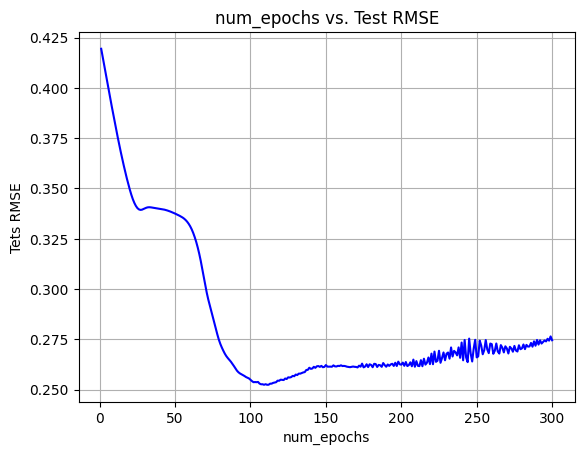

In [28]:
plt.plot(num_epochs_list, rmse_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test RMSE')
plt.xlabel('num_epochs')
plt.ylabel('Tets RMSE') 
plt.grid(True)
plt.show() 

In [29]:
min_rmse = min(rmse_list)
corresponding_r2_score = r2_scores_list[rmse_list.index(min_rmse)]
corresponding_num_epochs = num_epochs_list[rmse_list.index(min_rmse)]

print(f'Min RMSE score: {min_rmse}')
print(f'Corresponding R^2 SCore: {corresponding_r2_score}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Min RMSE score: 0.252418742693043
Corresponding R^2 SCore: 0.4294175562780569
Corresponding num_epochs: 111


#### Test R^2 Score vs. num_epochs

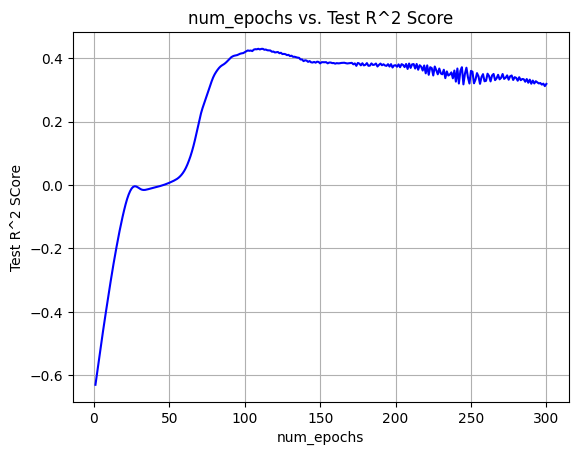

In [30]:
plt.plot(num_epochs_list, r2_scores_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test R^2 Score')
plt.xlabel('num_epochs')
plt.ylabel('Test R^2 SCore') 
plt.grid(True)
plt.show() 

In [31]:
max_r2_score = max(r2_scores_list)
corresponding_rmse = rmse_list[r2_scores_list.index(max_r2_score)]
corresponding_num_epochs = num_epochs_list[r2_scores_list.index(max_r2_score)]

print(f'Max R^2 score: {max_r2_score}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.4297347177742974
Corresponding RMSE: 0.25242890470958096
Corresponding num_epochs: 109


#### Test Adjsuted R^2 Score (Valence) vs. num_epochs

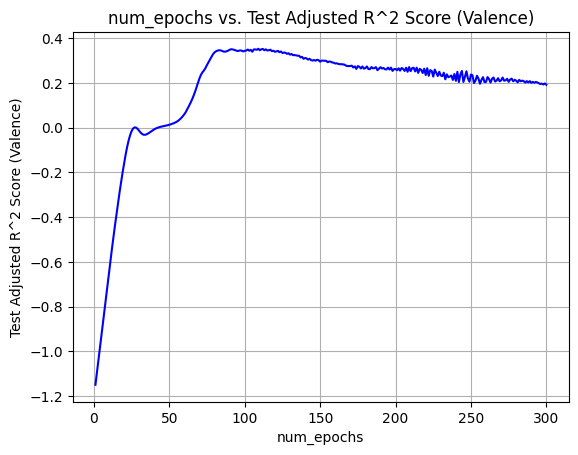

In [32]:
plt.plot(num_epochs_list, adjusted_r2_scores_valence_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Valence)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 Score (Valence)') 
plt.grid(True)
plt.show() 

In [33]:
max_r2_score_valence = max(adjusted_r2_scores_valence_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_valence_list.index(max_r2_score_valence)]

print(f'Max R^2 score: {max_r2_score_valence}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.35238747883047805
Corresponding RMSE: 0.25242890470958096
Corresponding num_epochs: 109


#### Test Adjusted R^2 Score (Arousal) vs. num_epochs

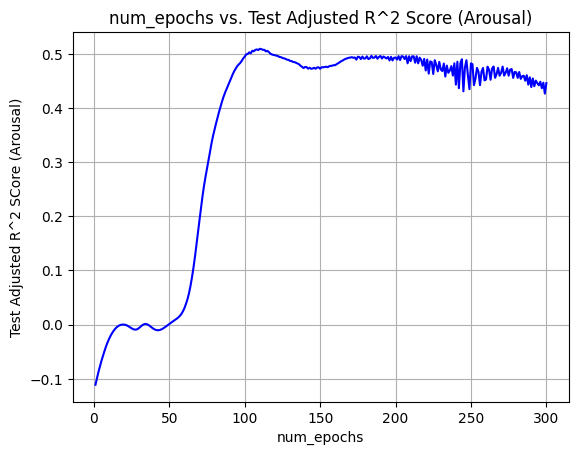

In [34]:
plt.plot(num_epochs_list, adjusted_r2_scores_arousal_list, color='b', linestyle='-')
plt.title('num_epochs vs. Test Adjusted R^2 Score (Arousal)')
plt.xlabel('num_epochs')
plt.ylabel('Test Adjusted R^2 SCore (Arousal)') 
plt.grid(True)
plt.show() 

In [35]:
max_r2_score_arousal = max(adjusted_r2_scores_arousal_list)
corresponding_rmse = rmse_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]
corresponding_num_epochs = num_epochs_list[adjusted_r2_scores_arousal_list.index(max_r2_score_arousal)]

print(f'Max R^2 score: {max_r2_score_arousal}')
print(f'Corresponding RMSE: {corresponding_rmse}')
print(f'Corresponding num_epochs: {corresponding_num_epochs}')

Max R^2 score: 0.5094110673130416
Corresponding RMSE: 0.2527105666519095
Corresponding num_epochs: 110
